# PSSM

> Functions related with PSSMs

## Setup

In [ ]:
#| default_exp pssm

In [ ]:
#| export
import numpy as np, pandas as pd
from katlas.data import *
from katlas.utils import *
from fastcore.meta import delegates
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from functools import partial
from fastcore.meta import delegates

# for plot
from matplotlib import pyplot as plt
import logomaker,math
import seaborn as sns

from matplotlib.colors import TwoSlopeNorm

# for plot two heatmaps
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter

# hierarchical clustering
from scipy.cluster.hierarchy import linkage, fcluster,dendrogram

# for type
from typing import Sequence

In [ ]:
#| hide
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 100) # show all columns

```python
from katlas.pssm import *
```

In [ ]:
#| hide
#| export
EPSILON = 1e-8

## PSSM

We need to compute **position-specific probability matrix (PSSM)** from a list of aligned site sequences.

For each position $i$ (e.g., from $-7$ to $+7$), the probability of observing amino acid $x$ is:

$$
P_i(x) = \frac{\text{count of amino acid } x \text{ at position } i}{\text{total counts at position } i}
$$

The following 23 amino acids are included:

- Standard amino acids:  
  `A`, `C`, `D`, `E`, `F`, `G`, `H`, `I`, `K`, `L`, `M`, `N`, `P`, `Q`, `R`, `S`, `T`, `V`, `W`, `Y`  
- Modified amino acids:  
  `s`, `t`, `y` (often used to denote phosphorylated `S`, `T`, `Y`)


The resulting matrix has:
- **Rows**: Amino acids,
- **Columns**: Sequence positions (centered on the phosphosite),
- **Values**: Probabilities of each amino acid at each position.

In [ ]:
#| export
def get_prob(data: pd.DataFrame | pd.Series | Sequence[str], # input data, list or df
             col: str='site_seq', # column name if input is df
             ):
    "Get the probability matrix of PSSM from phosphorylation site sequences."

    aa_order=[i for i in 'PGACSTVILMFYWHKRQNDEsty']

    if isinstance(data, pd.DataFrame):
        if col not in data.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame.")
        site = data[col]
    else:
        try:
            site = pd.Series(data,copy=False)
        except Exception:
            raise TypeError("Input must be a DataFrame, Series, or list of sequences.")
    
    
    site = check_seqs(site)
    
    site_array = np.array(site.apply(list).tolist())
    seq_len = site_array.shape[1]
    
    position = list(range(-(seq_len // 2), (seq_len // 2)+1)) # add 1 because range do not include the final num
    
    site_df = pd.DataFrame(site_array, columns=position)
    melted = site_df.melt(var_name='Position', value_name='aa')
    
    grouped = melted.groupby(['Position', 'aa']).size().reset_index(name='Count')
    grouped = grouped[grouped.aa.isin(aa_order)].reset_index(drop=True)
    
    pivot_df = grouped.pivot(index='aa', columns='Position', values='Count').fillna(0)
    pssm_df = pivot_df / pivot_df.sum()
    
    pssm_df = pssm_df.reindex(index=aa_order, columns=position, fill_value=0)
    # pssm_df = pssm_df.rename(index={'s': 'pS', 't': 'pT', 'y': 'pY'}) # convert sty to pS,pT,pY
    
    return pssm_df

In [ ]:
data = Data.get_ks_dataset()
data_k = data[data.kinase_uniprot=='P49841'] # CDK1

In [ ]:
get_prob(data_k, col='site_seq').shape

(23, 41)

In [ ]:
# or
pssm_df = get_prob(data_k['site_seq'].tolist())
pssm_df.tail()

Position,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
aa,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
D,0.059524,0.065476,0.044577,0.080238,0.051775,0.048744,0.047267,0.054572,0.064611,0.048387,0.052709,0.058565,0.049635,0.049563,0.071325,0.069666,0.058055,0.063768,0.037627,0.062229,0.000000,0.034783,0.046579,0.056934,0.030702,0.084919,0.064516,0.056464,0.051128,0.072289,0.059091,0.054962,0.033846,0.063174,0.053042,0.054859,0.063091,0.055380,0.054054,0.056090,0.053140
E,0.061012,0.066964,0.077266,0.056464,0.075444,0.075332,0.090103,0.094395,0.066079,0.095308,0.086384,0.070278,0.068613,0.083090,0.093159,0.076923,0.076923,0.053623,0.060781,0.069465,0.000000,0.023188,0.081514,0.075912,0.071637,0.080527,0.055718,0.063893,0.081203,0.078313,0.068182,0.087023,0.072308,0.064715,0.098284,0.073668,0.056782,0.072785,0.057234,0.057692,0.074074
s,0.037202,0.041667,0.035661,0.031204,0.038462,0.038405,0.044313,0.041298,0.070485,0.045455,0.049780,0.048316,0.103650,0.056851,0.059680,0.068215,0.223512,0.073913,0.082489,0.076700,0.677279,0.037681,0.081514,0.106569,0.274854,0.057101,0.076246,0.074294,0.129323,0.057229,0.054545,0.041221,0.083077,0.066256,0.045242,0.047022,0.069401,0.033228,0.063593,0.051282,0.045089
t,0.019345,0.010417,0.022288,0.019316,0.019231,0.016248,0.016248,0.011799,0.014684,0.020528,0.033675,0.036603,0.024818,0.017493,0.024745,0.039187,0.065312,0.030435,0.050651,0.026049,0.285094,0.021739,0.029112,0.037956,0.089181,0.033675,0.033724,0.040119,0.039098,0.031627,0.050000,0.025954,0.030769,0.015408,0.020281,0.010972,0.014196,0.015823,0.015898,0.014423,0.014493
y,0.004464,0.008929,0.007429,0.008915,0.008876,0.010340,0.007386,0.002950,0.005874,0.016129,0.010249,0.014641,0.005839,0.013120,0.014556,0.017417,0.007257,0.007246,0.005789,0.010130,0.037627,0.020290,0.007278,0.017518,0.019006,0.004392,0.004399,0.008915,0.006015,0.007530,0.006061,0.012214,0.007692,0.004622,0.012480,0.004702,0.006309,0.006329,0.012719,0.006410,0.011272


## Transform PSSM

In [ ]:
#| export
def flatten_pssm(pssm_df,
                 column_wise=True, # if True, column major flatten; else row wise flatten (for pytorch training)
                ):
    "Flatten PSSM dataframe to dictionary"
    
    pssm_df=pssm_df.copy()

    # Flatten a pssm_df
    # Column wise
    if column_wise: 
        pssm = pssm_df.unstack().reset_index(name='value')
        # Combine position column and residue identity column as new column for keys
        pssm['position_residue']=pssm.iloc[:,0].astype(str)+pssm.iloc[:,1]
        
    # Row wise
    else: 
        pssm = pssm_df.T.unstack().reset_index(name='value')
        pssm['position_residue']=pssm.iloc[:,1].astype(str)+pssm.iloc[:,0].astype(str)
    
    # Set index to be position+residue
    return pssm.set_index('position_residue')['value'].to_dict()

In [ ]:
flat_pssm = pd.Series(flatten_pssm(pssm_df))
flat_pssm

-20P    0.069940
-20G    0.087798
          ...   
20t     0.014493
20y     0.011272
Length: 943, dtype: float64

In [ ]:
flat_pssm.reset_index()[0]

0      0.069940
1      0.087798
         ...   
941    0.014493
942    0.011272
Name: 0, Length: 943, dtype: float64

In [ ]:
#| export
def recover_pssm(flat_pssm: pd.Series):
    "Recover 2D PSSM from flattened PSSM Series."
    df = flat_pssm.reset_index()
    df.columns=['index', 'value']
    df['Position'] = df['index'].str[:-1].astype(int)
    df['aa'] = df['index'].str[-1]

    df = df.pivot(index='aa', columns='Position', values='value').fillna(0)
    aa_order=tuple('PGACSTVILMFYWHKRQNDEsty')
    order = [aa for aa in aa_order if aa in df.index]
    return df.reindex(index=order)

In [ ]:
out = recover_pssm(flat_pssm)
out

Position,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
aa,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P,0.069940,0.077381,0.062407,0.084695,0.082840,0.072378,0.087149,0.081121,0.077827,0.071848,0.101025,0.074671,0.084672,0.106414,0.112082,0.094340,0.079826,0.133333,0.150507,0.131693,0.000000,0.420290,0.141194,0.094891,0.049708,0.187408,0.082111,0.077266,0.064662,0.106928,0.074242,0.077863,0.078462,0.070878,0.095164,0.092476,0.074132,0.090190,0.071542,0.099359,0.078905
G,0.087798,0.087798,0.069837,0.065379,0.076923,0.054653,0.088626,0.095870,0.064611,0.068915,0.070278,0.087848,0.058394,0.065598,0.066958,0.063861,0.068215,0.101449,0.076700,0.105644,0.000000,0.075362,0.065502,0.086131,0.046784,0.054173,0.060117,0.083210,0.084211,0.058735,0.063636,0.083969,0.084615,0.075501,0.076443,0.081505,0.067823,0.060127,0.077901,0.088141,0.066023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
t,0.019345,0.010417,0.022288,0.019316,0.019231,0.016248,0.016248,0.011799,0.014684,0.020528,0.033675,0.036603,0.024818,0.017493,0.024745,0.039187,0.065312,0.030435,0.050651,0.026049,0.285094,0.021739,0.029112,0.037956,0.089181,0.033675,0.033724,0.040119,0.039098,0.031627,0.050000,0.025954,0.030769,0.015408,0.020281,0.010972,0.014196,0.015823,0.015898,0.014423,0.014493
y,0.004464,0.008929,0.007429,0.008915,0.008876,0.010340,0.007386,0.002950,0.005874,0.016129,0.010249,0.014641,0.005839,0.013120,0.014556,0.017417,0.007257,0.007246,0.005789,0.010130,0.037627,0.020290,0.007278,0.017518,0.019006,0.004392,0.004399,0.008915,0.006015,0.007530,0.006061,0.012214,0.007692,0.004622,0.012480,0.004702,0.006309,0.006329,0.012719,0.006410,0.011272


In [ ]:
out.equals(pssm_df)

True

Or recover from PSPA data

In [ ]:
pspa = Data.get_pspa()

In [ ]:
pssm=recover_pssm(pspa.loc['AAK1'].dropna())
pssm

Position,-5,-4,-3,-2,-1,0,1,2,3,4
aa,,,,,,,,,,
P,0.0720,0.0534,0.1084,0.0226,0.1136,0.0,0.0463,0.0527,0.0681,0.0628
G,0.0245,0.0642,0.0512,0.0283,0.0706,0.0,0.7216,0.0749,0.0923,0.0702
...,...,...,...,...,...,...,...,...,...,...
t,0.0201,0.0332,0.0303,0.0209,0.0121,1.0,0.0123,0.0409,0.0335,0.0251
y,0.0611,0.0339,0.0274,0.0486,0.0178,0.0,0.0100,0.0410,0.0359,0.0270


PSPA is not scaled per position.

So we need to remove the redundant copy in zero position (leave s/t/y only) and scaled to 1 per position.

In [ ]:
pssm.index[pssm.index.isin(['s','t','y'])]

Index(['s', 't', 'y'], dtype='object', name='aa')

In [ ]:
#| export
def _clean_zero(pssm_df):
    "Zero out non-last three values in position 0 (keep only s,t,y values at center)"
    pssm_df = pssm_df.copy()
    standard_aa = list(set(pssm_df.index)-set(['s','t','y']))
    pssm_df.loc[standard_aa, 0] = 0
    return pssm_df

In [ ]:
_clean_zero(pssm)

Position,-5,-4,-3,-2,-1,0,1,2,3,4
aa,,,,,,,,,,
P,0.0720,0.0534,0.1084,0.0226,0.1136,0.0,0.0463,0.0527,0.0681,0.0628
G,0.0245,0.0642,0.0512,0.0283,0.0706,0.0,0.7216,0.0749,0.0923,0.0702
...,...,...,...,...,...,...,...,...,...,...
t,0.0201,0.0332,0.0303,0.0209,0.0121,1.0,0.0123,0.0409,0.0335,0.0251
y,0.0611,0.0339,0.0274,0.0486,0.0178,0.0,0.0100,0.0410,0.0359,0.0270


In [ ]:
#| export
def clean_zero_normalize(pssm_df):
    "Zero out non-last three values in position 0 (keep only s,t,y values at center), and normalize per position"
    pssm_df=pssm_df.copy()
    pssm_df.columns= pssm_df.columns.astype(int)
    pssm_df = _clean_zero(pssm_df)
    return pssm_df/pssm_df.sum()

This function applies phosphosite-specific cleaning and normalization to a PSSM.

At the center position ($i = 0$), only the last three rows of the matrix — corresponding to phosphorylatable residues `s`, `t`, and `y` — are retained. All other amino acid values at position 0 are set to 0.

After masking, the matrix is column-normalized to ensure the probabilities at each position sum to 1:

$$
P_i(x) = \frac{P_i(x)}{\sum_{x'} P_i(x')}
$$


In [ ]:
clean_zero_normalize(pssm)

Position,-5,-4,-3,-2,-1,0,1,2,3,4
aa,,,,,,,,,,
P,0.058446,0.041715,0.086100,0.017935,0.096068,0.000000,0.042649,0.040482,0.052640,0.050260
G,0.019888,0.050152,0.040667,0.022459,0.059704,0.000000,0.664702,0.057536,0.071346,0.056182
...,...,...,...,...,...,...,...,...,...,...
t,0.016316,0.025935,0.024067,0.016586,0.010233,0.908018,0.011330,0.031418,0.025895,0.020088
y,0.049598,0.026482,0.021763,0.038568,0.015053,0.000000,0.009211,0.031495,0.027750,0.021609


## PSSM of Log odds 

In [ ]:
#| export
def get_pssm_LO(pssm_df,
                site_type, # S, T, Y, ST, or STY
               ):
    "Get log odds PSSM: log2 (freq pssm/background pssm)."
    bg_pssms = Data.get_ks_background()
    flat_bg = bg_pssms.loc[f'ks_{site_type}']
    pssm_bg = recover_pssm(flat_bg)
    pssm_odds = ((pssm_df+EPSILON)/(pssm_bg+EPSILON)).dropna(axis=0,how='all').dropna(axis=1, how='all')
    # make sure all columns and index matched
    assert pssm_odds.shape == pssm_df.shape
    return np.log2(pssm_odds).replace([np.inf, -np.inf], 0).fillna(0)

Let $P_i(x)$ be the frequency of amino acid $x$ at position $i$ in the input PSSM, and let $B_i(x)$ be the background frequency of amino acid $x$ at the same position, derived from a background model corresponding to the specified site type (`S`, `T`, `Y`, or `STY`).

The log-odds score at each position $i$ for amino acid $x$ is computed as:

$$
\mathrm{LO}_i(x) = \log_2 \left( \frac{P_i(x) + \varepsilon}{B_i(x) + \varepsilon} \right)
$$

where $\varepsilon = 10^{-8}$ is a small constant added for numerical stability and to avoid division by zero.

This results in a matrix where:

- Positive values indicate enrichment over background,
- Negative values indicate depletion relative to background,
- Zero indicates no difference from the expected background.

In [ ]:
data_y = data_k[data_k.site.str[0]=='Y']

In [ ]:
pssm_y = get_prob(data_y,'site_seq')

In [ ]:
pssm_LO = get_pssm_LO(pssm_y,'Y')
pssm_LO.head()

Position,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
aa,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P,-22.421662,-0.512361,-22.483757,-0.441300,-22.330630,1.127181,0.556571,-22.472709,-22.395309,-22.472370,-22.494346,-0.498220,0.362731,-22.282520,-22.393568,-0.658704,0.401814,-22.316020,0.711607,-22.159026,0.0,-21.219306,-22.470595,-22.994372,-22.573771,2.500636,0.457348,1.192256,-22.627742,1.636288,-0.497208,-22.614291,-0.295385,-0.334330,-22.595771,0.856785,0.132517,-22.489922,-22.515220,-22.349670,-22.682968
G,2.143585,2.259460,0.275900,0.699035,-22.708532,-0.749012,0.962707,-0.786810,-0.692558,-22.752478,0.175936,0.227255,0.291871,1.651462,0.762874,-0.765860,-1.010588,-22.841111,-0.008750,-0.610321,0.0,1.045771,1.222666,-22.301926,2.115713,0.180116,-0.599896,-22.557503,-0.735659,-22.691406,-22.606718,1.180075,0.444924,-22.716477,1.039133,-0.027003,-0.045322,-0.093640,-22.828378,0.077856,-0.148372
A,-0.821010,-22.787101,-22.593992,-22.501932,-22.687021,2.118529,-0.733631,-0.709477,0.848204,1.176168,-0.930771,-0.820148,0.359434,-0.644471,-22.685439,0.194020,-22.568254,0.155705,-22.719076,-22.414048,0.0,-0.833935,1.577583,-22.495567,-22.470923,-22.548438,-0.825586,1.019478,0.525050,-0.821217,-22.715532,-22.607643,-0.783671,1.415181,1.795060,1.573972,0.886847,0.885076,0.998036,2.420744,1.066110
C,-20.604884,-20.821590,-20.610481,2.820191,1.226090,-20.613911,-20.674559,-20.555965,-20.395309,-20.465246,-20.723212,-20.683076,-20.273082,-20.562865,3.365323,-20.637713,-20.490617,-20.197935,-20.073742,-20.197731,0.0,-20.723779,2.562935,-20.857363,1.456954,-20.380203,-20.784654,-20.540430,1.726683,1.964277,-20.474525,-20.292364,4.183644,-20.827394,-20.497208,-20.411330,-20.843591,-20.777410,-20.951953,-20.735729,-20.464922
S,0.846942,-22.150318,2.316723,-0.128025,-22.210853,-22.220374,2.079367,0.768343,2.167026,-21.971941,-21.907636,-21.850281,-22.021350,0.783742,-21.770936,-21.831141,2.757737,-21.627747,-21.621229,-21.092120,0.0,-21.500400,-21.519269,-21.615861,-22.015041,-22.077133,-21.879565,-21.929472,-21.962609,-21.994476,-21.856395,-22.144041,-22.079396,-22.071062,0.543296,-22.129558,-22.149269,1.464015,-22.361597,-22.234534,1.394090


In [ ]:
pssm_y[0][pssm_y[0]==1].index

Index(['y'], dtype='object', name='aa')

In [ ]:
pssm_LO[0].sort_values() # log-odds is zero at center position when single site log-odds pssm

aa
P    0.0
G    0.0
    ... 
t    0.0
y    0.0
Name: 0, Length: 23, dtype: float64

In [ ]:
#| export
def get_pssm_LO_flat(flat_pssm,
                    site_type, # S, T, Y, ST, or STY
                    ):
    pssm_df = recover_pssm(flat_pssm)
    return get_pssm_LO(pssm_df,site_type)

In [ ]:
pssm_LO = get_pssm_LO_flat(flat_pssm,'STY')
pssm_LO

Position,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
aa,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P,0.059908,0.281140,-0.026749,0.355318,0.346468,0.178779,0.463147,0.308758,0.239997,0.179283,0.608034,0.192985,0.329370,0.721201,0.715760,0.588674,0.320993,1.112040,0.973481,1.055403,0.000000,1.539081,1.109428,0.434700,-0.301588,1.379883,0.314032,0.243357,-0.060158,0.644231,0.061865,0.161917,0.308782,0.140834,0.521194,0.373708,0.158627,0.462854,0.138734,0.658643,0.216764
G,0.355425,0.331928,0.015762,-0.090070,0.155057,-0.318908,0.274539,0.486357,-0.081333,-0.044640,-0.023817,0.297183,-0.167014,-0.096944,-0.092276,-0.064319,-0.075365,0.473975,0.243292,0.358158,0.000000,0.235499,-0.025131,0.284594,-0.457652,-0.327199,-0.123033,0.303309,0.315783,-0.190655,-0.067465,0.298568,0.361469,0.170286,0.215167,0.258789,-0.054255,-0.185829,0.200256,0.388134,-0.066157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
t,0.338037,-0.508472,0.536544,0.409825,0.546294,0.066828,0.190809,-0.298146,0.023876,0.295761,0.995227,1.015112,0.246666,-0.332277,0.195250,0.680780,1.210743,0.166721,0.546415,-0.157283,0.329833,-0.420698,-0.286888,0.507349,1.536109,0.349480,0.508819,1.032751,0.944610,0.697806,1.386345,0.723589,0.986439,-0.036165,0.368048,-0.516571,-0.021008,0.119857,0.161114,-0.047991,-0.097686
y,-1.109821,0.265760,-0.184739,0.075387,0.307806,0.041911,-0.180464,-1.440588,-0.516052,0.508038,-0.011805,0.496492,-0.749242,0.261563,0.139186,0.233321,-1.138437,-1.195610,-1.747661,-1.166771,-2.655631,-0.065791,-1.535247,-0.045814,0.191191,-1.732180,-1.613038,-0.465142,-0.886647,-0.336320,-0.712011,0.069406,-0.161659,-0.829713,0.474154,-0.851437,-0.438485,-0.267581,0.642920,-0.356680,0.230591


## PSSMs of clusters

In [ ]:
#| export
def get_cluster_pssms(df, 
                    cluster_col, 
                    seq_col='site_seq', 
                    id_col = 'sub_site',
                    count_thr=10, # if less than the count threshold, not include in the return
                    valid_thr=None, # percentage of not-nan values in pssm
                    IC_thr = None,
                      plot=False):
    "Extract motifs from clusters in a dataframe"
    pssms = []
    ids = []
    # drop duplicates based both on cluster column and substrate seq id column
    value_counts = df.drop_duplicates(subset=[cluster_col,id_col])[cluster_col].value_counts()
    for cluster_id, counts in tqdm(value_counts.items(),total=len(value_counts)):
        if count_thr is not None and counts < count_thr:
            continue

        if id_col is not None:
            df_cluster = df[df[cluster_col] == cluster_id].drop_duplicates(id_col)
        else:
            df_cluster = df[df[cluster_col] == cluster_id]
        
        n= len(df_cluster)
        pssm = get_prob(df_cluster, seq_col)
        valid_score = (pssm != 0).sum().sum() / (pssm.shape[0] * pssm.shape[1])

        if valid_thr is not None and valid_score <= valid_thr:
            continue

        pssms.append(flatten_pssm(pssm))
        ids.append(cluster_id)

        if plot:
            plot_logo(pssm, title=f'Cluster {cluster_id} (n={n})', figsize=(14, 1))
            plt.show()
            plt.close()

    pssm_df = pd.DataFrame(pssms, index=ids)
    return pssm_df

In [ ]:
get_cluster_pssms(data,'kinase_group')

100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.70it/s]


,-20P,-20G,-20A,-20C,-20S,-20T,-20V,-20I,-20L,-20M,-20F,-20Y,-20W,-20H,-20K,-20R,-20Q,-20N,-20D,-20E,-20s,-20t,-20y,-19P,-19G,-19A,-19C,-19S,-19T,-19V,-19I,-19L,-19M,-19F,-19Y,-19W,-19H,-19K,-19R,-19Q,-19N,-19D,-19E,-19s,-19t,-19y,-18P,-18G,-18A,-18C,...,18E,18s,18t,18y,19P,19G,19A,19C,19S,19T,19V,19I,19L,19M,19F,19Y,19W,19H,19K,19R,19Q,19N,19D,19E,19s,19t,19y,20P,20G,20A,20C,20S,20T,20V,20I,20L,20M,20F,20Y,20W,20H,20K,20R,20Q,20N,20D,20E,20s,20t,20y
TK,0.056754,0.069067,0.070474,0.016886,0.045028,0.039400,0.058630,0.049836,0.083255,0.024038,0.032716,0.023335,0.007974,0.021107,0.069184,0.056168,0.045966,0.036585,0.058865,0.081027,0.024508,0.011843,0.017355,0.057915,0.067158,0.073125,0.016731,0.045396,0.037440,0.053001,0.049959,0.087633,0.023751,0.031356,0.018018,0.009594,0.022230,0.074529,0.063999,0.043173,0.041652,0.060840,0.073359,0.025389,0.010881,0.012870,0.058123,0.067810,0.062792,0.014006,...,0.080097,0.027670,0.012621,0.012743,0.058601,0.065424,0.065302,0.014864,0.045078,0.038986,0.056408,0.048124,0.087354,0.018884,0.042276,0.017178,0.008894,0.018519,0.073830,0.061769,0.047149,0.040327,0.059698,0.078216,0.028509,0.010599,0.014011,0.066015,0.072738,0.065037,0.013692,0.048900,0.037897,0.054523,0.050122,0.077262,0.023227,0.039364,0.018337,0.008435,0.019071,0.070905,0.059413,0.040465,0.038509,0.056357,0.083496,0.025917,0.012836,0.017482
CMGC,0.080589,0.070340,0.083792,0.013709,0.050865,0.035874,0.053812,0.035874,0.074824,0.022037,0.029468,0.015247,0.007559,0.020884,0.069058,0.057143,0.044331,0.032031,0.053299,0.078668,0.042921,0.020115,0.007559,0.079718,0.075496,0.072937,0.012028,0.058733,0.035061,0.053871,0.032885,0.074472,0.021753,0.026104,0.013436,0.007806,0.021241,0.064491,0.063596,0.046449,0.037492,0.055534,0.080614,0.042482,0.018298,0.005502,0.074292,0.068930,0.074419,0.013786,...,0.084768,0.052185,0.016556,0.005960,0.074212,0.073813,0.074212,0.011970,0.053731,0.034047,0.050805,0.031520,0.074345,0.017423,0.028195,0.015029,0.010374,0.020215,0.070887,0.063173,0.045884,0.033914,0.056124,0.086980,0.048278,0.018619,0.006251,0.082465,0.066961,0.074980,0.012563,0.050789,0.034215,0.050521,0.038626,0.079925,0.019246,0.028869,0.016840,0.006816,0.023924,0.072307,0.060011,0.046111,0.035285,0.057070,0.074044,0.043972,0.018043,0.006415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CK1,0.057860,0.076419,0.076965,0.014192,0.039847,0.037118,0.063865,0.052402,0.070961,0.017467,0.027293,0.012555,0.014192,0.024017,0.079694,0.050764,0.033297,0.035480,0.058406,0.086790,0.038210,0.015830,0.016376,0.061069,0.070883,0.069793,0.007634,0.033806,0.032715,0.053435,0.043075,0.087786,0.023991,0.022901,0.016903,0.010905,0.020720,0.076881,0.059978,0.056161,0.037077,0.061069,0.087786,0.041439,0.017448,0.006543,0.050000,0.067935,0.073913,0.010870,...,0.084629,0.041451,0.015544,0.012090,0.053148,0.068746,0.069324,0.012709,0.036973,0.021953,0.047371,0.042172,0.082034,0.017909,0.030040,0.017909,0.020220,0.019064,0.095321,0.047371,0.041594,0.034084,0.065280,0.098209,0.041594,0.021953,0.015020,0.051865,0.074592,0.088578,0.015152,0.039627,0.034382,0.055361,0.039627,0.074592,0.020979,0.034382,0.020396,0.008741,0.026224,0.079837,0.046620,0.038462,0.043124,0.067599,0.087995,0.027972,0.012238,0.011655
Atypical,0.071895,0.065359,0.063492,0.014939,0.053221,0.045752,0.058824,0.050420,0.085901,0.020542,0.017740,0.020542,0.005602,0.034547,0.049486,0.057890,0.040149,0.034547,0.059757,0.078431,0.041083,0.025210,0.004669,0.042870,0.052190,0.074557,0.013979,0.063374,0.036347,0.054986,0.031687,0.089469,0.027959,0.036347,0.015843,0.010252,0.026095,0.074557,0.056850,0.054054,0.034483,0.063374,0.068966,0.046598,0.018639

## Entropy

In [ ]:
#| export
def get_entropy(pssm_df,# a dataframe of pssm with index as aa and column as position
            return_min=False, # return min entropy as a single value or return all entropy as a pd.series
            exclude_zero=False, # exclude the column of 0 (center position) in the entropy calculation
            clean_zero=True, # if true, zero out non-last three values in position 0 (keep only s,t,y values at center)
            ): 
    "Calculate entropy per position of a PSSM surrounding 0. The less entropy the more information it contains."
    pssm_df = pssm_df.copy()
    pssm_df.columns= pssm_df.columns.astype(int)
    if 0 in pssm_df.columns:
        if clean_zero:                       
            pssm_df = _clean_zero(pssm_df)
        if exclude_zero:
            # remove columns starts with zero and columns with interger name 0
            cols_to_drop = [col for col in pssm_df.columns 
                            if col == 0 or (isinstance(col, str) and col.startswith('0'))]
            if cols_to_drop: pssm_df = pssm_df.drop(columns=cols_to_drop)

    pssm_df = pssm_df/pssm_df.sum()
    per_position = -np.sum(pssm_df * np.log2(pssm_df + EPSILON), axis=0)
    per_position[pssm_df.sum() == 0] = 0
    return float(per_position.min()) if return_min else per_position

Let $P_i(x)$ be the probability of amino acid $x$ at position $i$ in the PSSM, with $i \in \{-k, \dots, -1, 0, +1, \dots, +k\}$. The entropy at each position $i$ is defined as:

$$
H_i = - \sum_{x} P_i(x) \log_2 \left( P_i(x) + \varepsilon \right)
$$

where $\varepsilon = 10^{-8}$ is a small constant added for numerical stability.

If `exclude_zero=True`, the central position $i = 0$ is omitted from the entropy calculation.

If `clean_zero=True`, all values at position $i = 0$ are zeroed out except for amino acids Serine (S), Threonine (T), and Tyrosine (Y), typically the only possible phospho-acceptors in kinase motif analysis.

If `return_min=True`, the function returns the minimum entropy across all positions:

$$
H_{\text{spec}} = \min_i H_i
$$

Otherwise, the function returns the full vector $\{H_i\}$ for each position $i$, reflecting how much information (or uncertainty) is contained at each position in the motif.


In [ ]:
# get entropy per position
get_entropy(pssm_df).sort_values()

Position
 0     1.074964
 1     3.346861
         ...   
-9     4.297737
-12    4.302189
Length: 41, dtype: float64

In [ ]:
# calculate minimum entropy of surrouding positions
get_entropy(pssm_df,return_min=True,exclude_zero=True)

3.3468606104695913

In [ ]:
#| export
@delegates(get_entropy)
def get_entropy_flat(flat_pssm:pd.Series,**kwargs): 
    "Calculate entropy per position of a flat PSSM surrounding 0"
    pssm_df = recover_pssm(flat_pssm)
    return get_entropy(pssm_df,**kwargs)

In [ ]:
get_entropy_flat(flat_pssm).sort_values()

Position
 0     1.074964
 1     3.346861
         ...   
-9     4.297737
-12    4.302189
Length: 41, dtype: float64

In [ ]:
get_entropy_flat(flat_pssm,return_min=True,exclude_zero=True)

3.3468606104695913

In [ ]:
# test equal
(get_entropy_flat(flat_pssm).round(5) == get_entropy(pssm_df).round(5)).value_counts()

True    41
Name: count, dtype: int64

## Information Content

In [ ]:
#| export
@delegates(get_entropy)
def get_IC(pssm_df,**kwargs):
    """
    Calculate the information content (bits) from a frequency matrix,
    using log2(3) for the middle position and log2(len(pssm_df)) for others.
    The higher the more information it contains.
    """
    
    entropy_position = get_entropy(pssm_df,**kwargs)
    
    max_entropy_array = pd.Series(np.log2(len(pssm_df)), index=entropy_position.index)

    # set exclude_zero to False
    exclude_zero = kwargs.get('exclude_zero', False)
    if exclude_zero is False: max_entropy_array[0] = np.log2(3)

    # information_content = max_entropy - entropy --> log2(N) - entropy
    IC_position = max_entropy_array - entropy_position

    # if entropy is zero, set to zero as there's no value
    IC_position[entropy_position == 0] = 0
    return IC_position

Let $P_i(x)$ be the frequency (probability) of amino acid $x$ at position $i$ in the PSSM. The standard information content (IC) at position $i$ is defined as:

$$
\mathrm{IC}_i = \max H_i - H_i
$$

which is:

$$
\mathrm{IC}_i = \log_2(N) - H_i
$$

where $N$ is the number of possible amino acids (i.e., $N = \text{len}(P_i)$).

At the center position ($i = 0$), only three amino acids (S, T, Y) are relevant, so the maximum entropy at each position is defined as:

$$
\max H_i =
\begin{cases}
\log_2(3) & \text{if } i = 0 \\
\log_2(N) & \text{otherwise}
\end{cases}
$$


In [ ]:
# the higher the more conserved
get_IC(pssm_df,exclude_zero=True).sort_values()

Position
-12    0.221373
-9     0.225825
         ...   
 4     0.717760
 1     1.176701
Length: 40, dtype: float64

Check all zero cases:

In [ ]:
pssm_df2=pssm_df.copy()

In [ ]:
pssm_df2[-20]=0

In [ ]:
get_entropy(pssm_df2,exclude_zero=True).sort_values()

Position
-20    0.000000
 1     3.346861
         ...   
-9     4.297737
-12    4.302189
Length: 40, dtype: float64

In [ ]:
#| export
@delegates(get_IC)
def get_IC_flat(flat_pssm:pd.Series,**kwargs):
    """Calculate the information content (bits) from a flattened pssm pd.Series,
    using log2(3) for the middle position and log2(len(pssm_df)) for others."""
    
    pssm_df = recover_pssm(flat_pssm)
    return get_IC(pssm_df,**kwargs)

In [ ]:
get_IC_flat(flat_pssm,exclude_zero=True).sort_values()

Position
-12    0.221373
-9     0.225825
         ...   
 4     0.717760
 1     1.176701
Length: 40, dtype: float64

In [ ]:
(get_IC_flat(flat_pssm).round(5) == get_IC(pssm_df).round(5)).value_counts()

True    41
Name: count, dtype: int64

## Overall specificity

In [ ]:
#| export
def get_specificity(pssm_df):
    "Get specificity score of a pssm, excluding zero position."
    ICs = get_IC(pssm_df, exclude_zero=True)
    # only consider IC with values
    ICs= ICs[ICs > 0]
    return float(2*ICs.max()+ICs.var())

We evaluated the overall specificity of a PSSM by combining two metrics: the maximum IC across surrounding positions and the variance of IC values:

$$
\text{Specificity Score} = 2 \times \max(\text{IC}) + \mathrm{Var}(\text{IC})
$$

In [ ]:
get_specificity(pssm_df)

2.381609408364424

In [ ]:
#| export
def get_specificity_flat(flat_pssm):
    "Get specificity score of a pssm, excluding zero position."
    ICs = get_IC_flat(flat_pssm, exclude_zero=True)
    return float(2*ICs.max()+ICs.var())

In [ ]:
get_specificity_flat(flat_pssm)

2.381609408364424

## Plot

### Heatmap

In [ ]:
#| export
@delegates(sns.heatmap)
def plot_heatmap_simple(matrix, # a matrix of values
                 title: str='heatmap', # title of the heatmap
                 figsize: tuple=(6,7), # (width, height)
                 cmap: str='binary', # color map, default is dark&white
                 **kwargs, # arguments for sns.heatmap()
                 ):
    
    "Plot heatmap based on a matrix of values"
    
    plt.figure(figsize=figsize)
    sns.heatmap(matrix, square=True,cmap=cmap, annot=False,**kwargs)
    plt.title(title)
    plt.ylabel('')
    plt.xlabel('')
    plt.yticks(rotation=0)

In [ ]:
# plot_heatmap_simple(pssm_df,'kinase',figsize=(10,7))

In [ ]:
#| hide
#| export
def sty2pSTY_df(df):
    df=df.copy()
    df.index = df.index.map(sty2pSTY)
    return df

In [ ]:
#| export
def plot_heatmap(heatmap_df, ax=None, position_label=True, figsize=(5, 6), include_zero=True,scale_pos_neg=False, colorbar_title='Prob.'):
    "Plot a heatmap of pssm."
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    heatmap_df = sty2pSTY_df(heatmap_df)
    mask = np.zeros_like(heatmap_df, dtype=bool)
    zero_position = len(heatmap_df.columns) // 2
    second_position = math.ceil(len(heatmap_df.columns) / 2)
    # If they overlap, move the second line one step to the right (if possible)
    if second_position == zero_position: second_position = second_position + 1

    if not include_zero:
        mask[:, zero_position] = True  # Mask position 0 if include_zero is False

    if scale_pos_neg:
        vmin,vmax = heatmap_df.min().min(),heatmap_df.max().max()
        norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        sns.heatmap(
            heatmap_df,
            cmap='coolwarm',
            norm=norm,
            linewidth=0.3,
            ax=ax,
            mask=mask
        )
    else:
        sns.heatmap(
            heatmap_df,
            cmap='coolwarm',
            center=0,  # Center for diverging colormap
            linewidth=0.3,
            ax=ax,
            mask=mask
        )


    # Access and format the color bar
    colorbar = ax.collections[0].colorbar
    colorbar.ax.set_title(colorbar_title, loc='center')

    # Add vertical lines
    ax.axvline(zero_position, color='black', linewidth=0.5)
    ax.axvline(second_position, color='black', linewidth=0.5)

    # Format the heatmap border
    ax.patch.set_edgecolor("black")
    ax.patch.set_linewidth(1.5)

    # Hide axis labels
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.xaxis.set_ticks_position('top')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    if not position_label:
        ax.set_xticklabels([])

    return ax

This function visualizes a PSSM or log-odds matrix as a heatmap with diverging color scales centered at 0.

**Color scale behavior**:

- By default (`scale_pos_neg=False`), the colormap is **centered at 0**, but the full data range determines the color intensity:

  $$
  \text{color range} = [\min(\text{data}), \max(\text{data})], \quad \text{with center at } 0
  $$

  This is useful when you want to emphasize whether values are **above or below zero**, but without enforcing symmetry.

- If `scale_pos_neg=True`, the function uses a **balanced diverging scale** via `TwoSlopeNorm`, such that:

  $$
  \text{min color} = \min(\text{data}), \quad
  \text{center} = 0, \quad
  \text{max color} = \max(\text{data})
  $$

  The positive and negative ranges are **scaled separately**, ensuring that both ends of the heatmap have equal visual weight — especially helpful for symmetric data like log-odds matrices.

**Additional visual features**:
- The center position ($i = 0$) can be masked out using `include_zero=False`.

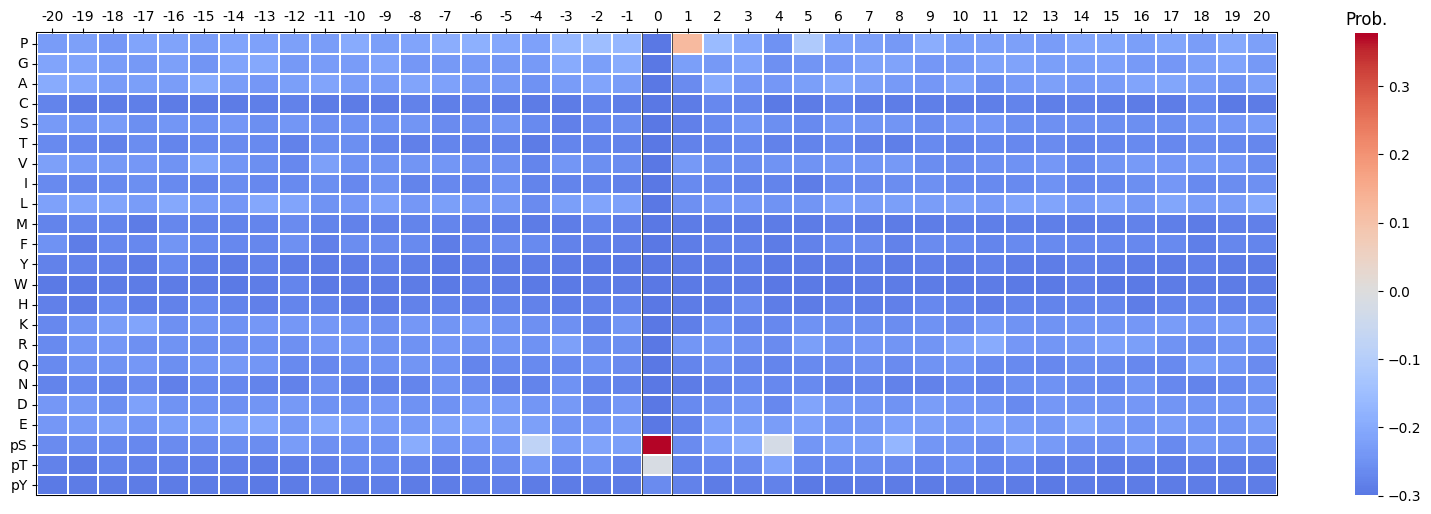

In [ ]:
plot_heatmap(pssm_df-0.3,scale_pos_neg=False,figsize=(20, 6));

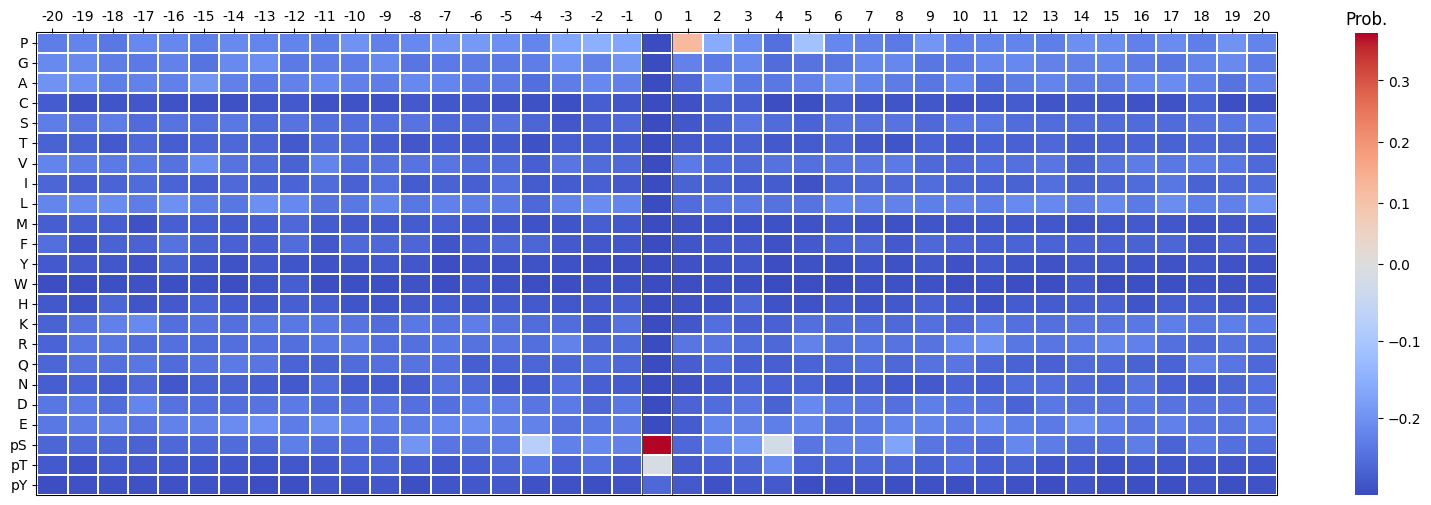

In [ ]:
plot_heatmap(pssm_df-0.3,scale_pos_neg=True,figsize=(20, 6));

In [ ]:
plt.close('all')

In [ ]:
#| export
def plot_two_heatmaps(pssm1, pssm2, 
                      kinase_name="Kinase", title1='CDDM',title2='PSPA',
                      figsize=(4,4.5), cbar=True,scale_01=False,
                      **kwargs):
    """
    Plot two side-by-side heatmaps with black rectangle borders,
    titles on top, shared kinase label below, and only left plot showing y-axis labels.
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'wspace': 0.05})
    pssm1 = pssm1.drop(columns=0)
    pssm2 = pssm2.drop(columns=0)

    pssm1 = sty2pSTY_df(pssm1)
    # pssm2 = sty2pSTY_df(pssm2)

    # Left heatmap (with y labels)
    im1=sns.heatmap(pssm1, square=False, cmap="Reds", 
                    **{'vmin':0, 'vmax':1} if scale_01 else {},
                annot=False, cbar=False, ax=axes[0], **kwargs)
    axes[0].set_title(title1, fontsize=12, pad=10)
    axes[0].tick_params(left=True, bottom=True)
    axes[0].tick_params(axis="y", rotation=0) 

    # Add rectangle border to left heatmap
    axes[0].add_patch(Rectangle((0,0), pssm1.shape[1], pssm1.shape[0], 
                                fill=False, edgecolor='black', lw=1.5))

    # Right heatmap (no y labels)
    im2=sns.heatmap(pssm2, square=False, cmap="Blues",
                    **{'vmin':0, 'vmax':1} if scale_01 else {},
                annot=False, cbar=False, ax=axes[1], **kwargs)
    axes[1].set_title(title2, fontsize=12, pad=10)
    axes[1].tick_params(left=False, labelleft=False, bottom=True)
    axes[1].tick_params(axis="y", rotation=0) 

    # Add rectangle border to right heatmap
    axes[1].add_patch(Rectangle((0,0), pssm2.shape[1], pssm2.shape[0], 
                                fill=False, edgecolor='black', lw=1.5))

    # Make y tick horizontal
    axes[0].set_title(title1, fontsize=12, pad=0)
    axes[1].set_title(title2, fontsize=12, pad=0)

    # ---- Add vertical separator lines ----
    xpos = (list(pssm1.columns).index(-1) + list(pssm1.columns).index(1)) / 2 + 0.5
    for ax in axes:
        ax.axvline(xpos, color='black', lw=0.75)
        ax.set_xticks([])
        # ax.set_xlabel("")
        ax.set_ylabel("")

    if cbar:
        for ax, im, label in zip(axes, [im1, im2], [title1, title2]):
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="5%", pad=0.25)
            cbar = plt.colorbar(ax.collections[0], cax=cax, orientation="horizontal")
            
            # remove trailing zeros like 0.00 → 0, 1.00 → 1
            cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:g}"))
            cax.tick_params(labelsize=8)

    # Shared kinase label below
    fig.suptitle(kinase_name, fontsize=14, x=0.52,y=0.96)

In [ ]:
pssm1 = recover_pssm(pspa.loc['AKT1'].dropna())
pssm2 = recover_pssm(pspa.loc['AKT2'].dropna())

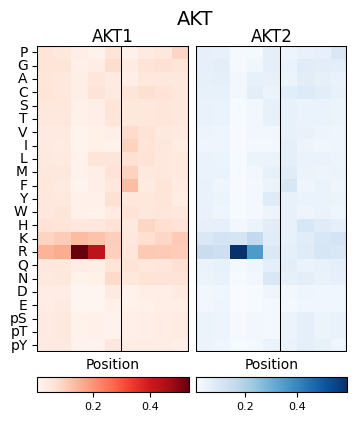

In [ ]:
plot_two_heatmaps(pssm1,pssm2,'AKT','AKT1','AKT2')

### Logo motif

In [ ]:
#| export
def plot_logo_raw(pssm_df,ax=None,title='Motif',ytitle='Bits',figsize=(10,2)):
    "Plot logo motif using Logomaker."
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # convert s,t,y to pS,pT,pY for visualization
    pssm_df=sty2pSTY_df(pssm_df)

    logo = logomaker.Logo(pssm_df.T, color_scheme='kinase_protein', flip_below=False, ax=ax)
    logo.ax.set_ylabel(ytitle)
    logo.style_xticks(fmt='%d')
    ax.set_title(title)

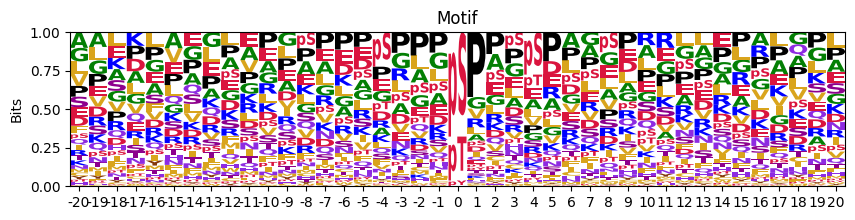

In [ ]:
plot_logo_raw(pssm_df)

We can find the center name is in lower case, so need to change them

In [ ]:
#| export
def change_center_name(df):
    "Transfer the middle s,t,y to S,T,Y for plot if s,t,y have values; otherwise keep the original."
    df=df.copy()
    
    if not (df.loc[['s','t','y'],0]==0).all():
        df.loc['S', 0] = df.loc['s', 0]
        df.loc['T', 0] = df.loc['t', 0]
        df.loc['Y', 0] = df.loc['y', 0]
        df.loc[['s', 't', 'y'], 0] = 0
    return df

Now instead of s,t,y, the center name becomes S, T and Y:

In [ ]:
change_center_name(pssm_df)[0]

aa
P    0.0
G    0.0
    ... 
t    0.0
y    0.0
Name: 0, Length: 23, dtype: float64

In [ ]:
#| export
def get_pos_min_max(pssm_df):
    """
    Get min and max value of sum of positive and negative values across each position.
    """
    pssm_df = pssm_df.copy()
    pssm_neighbor = pssm_df.drop(columns=0)
    
    max_sum_pos = pssm_neighbor[pssm_neighbor>0].sum().max()
    max_sum_neg = pssm_neighbor[pssm_neighbor<0].sum().min()
    return max_sum_neg,max_sum_pos

In [ ]:
#| export
def scale_zero_position(pssm_df):
    """
    Scale position 0 so that:
    - Positive values match the max positive column sum of other positions
    - Negative values match the min (most negative) column sum of other positions
    """
    max_sum_neg,max_sum_pos = get_pos_min_max(pssm_df)

    zero_col = pssm_df[0]
    zero_col_pos = zero_col[zero_col>0]
    zero_col_neg = zero_col[zero_col<0]
    
    scaled_col = zero_col.copy()
    if not zero_col_pos.empty and zero_col_pos.sum() != 0:
        scaled_col.loc[zero_col_pos.index] = max_sum_pos * (zero_col_pos / zero_col_pos.sum())
    if not zero_col_neg.empty and zero_col_neg.sum() != 0:
        scaled_col.loc[zero_col_neg.index] = max_sum_neg * (zero_col_neg / zero_col_neg.sum())

    pssm_df[0] = scaled_col
    return pssm_df
    

This function rescales **position 0** in a log-odds PSSM so that its total positive and negative stack heights match those of the most extreme positions on either side.

This ensures the central position visually matches the dynamic range of surrounding positions in log-odds logo plots.


In [ ]:
#| export
def scale_pos_neg_values(pssm_df):
    """
    Globally scale all positive values by max positive column sum,
    and negative values by min negative column sum (preserving sign).
    """
    pssm_df = pssm_df.copy()
    max_sum_neg, max_sum_pos = get_pos_min_max(pssm_df)

    pos_part = pssm_df.clip(lower=0)
    neg_part = pssm_df.clip(upper=0)

    if max_sum_pos != 0: pos_part = pos_part / max_sum_pos
    if max_sum_neg != 0: neg_part = neg_part / abs(max_sum_neg)  # make sure sign is correct

    return pos_part + neg_part

In [ ]:
#| export
def convert_logo_df(pssm_df,scale_zero=True,scale_pos_neg=False):
    "Change center name from s,t,y to S, T, Y in a pssm and scaled zero position to the max of neigbors."
    pssm_df = change_center_name(pssm_df)
    if scale_zero: pssm_df = scale_zero_position(pssm_df)
    if scale_pos_neg: pssm_df = scale_pos_neg_values(pssm_df)
    return pssm_df

In [ ]:
#| export
def get_logo_IC(pssm_df):
    """
    For plotting purpose, calculate the scaled information content (bits) from a frequency matrix,
    using log2(3) for the middle position and log2(len(pssm_df)) for others.
    """
    IC_position = get_IC(pssm_df)
    
    return pssm_df.mul(IC_position, axis=1) # total_IC = pssm_df.sum().sum().round(2)



To visualize the motif using Logomaker, the scaled PSSM is computed by weighting each amino acid’s frequency at position $i$ by the position’s information content:

$$
\text{PSSM\_scaled}_i(x) = P_i(x) \cdot \mathrm{IC}_i
$$

This results in a matrix where the total stack height at each position equals the information content, and each letter’s height is proportional to its contribution. This is the standard format used by Logomaker to generate sequence logos.


In [ ]:
get_logo_IC(pssm_df)

Position,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
aa,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P,0.019652,0.026918,0.015665,0.023951,0.020766,0.018778,0.025329,0.023845,0.017229,0.019292,0.026572,0.016862,0.022977,0.032447,0.030862,0.022572,0.043840,0.056881,0.058556,0.051823,0.000000,0.494556,0.054836,0.026297,0.035678,0.097961,0.024077,0.020674,0.023837,0.026058,0.020890,0.020991,0.020345,0.019011,0.022280,0.027848,0.021000,0.027223,0.017312,0.029500,0.021873
G,0.024669,0.030542,0.017530,0.018489,0.019283,0.014179,0.025758,0.028180,0.014303,0.018504,0.018485,0.019838,0.015846,0.020002,0.018437,0.015279,0.037463,0.043279,0.029841,0.041572,0.000000,0.088679,0.025439,0.023870,0.033579,0.028317,0.017628,0.022265,0.031043,0.014314,0.017906,0.022637,0.021941,0.020251,0.017897,0.024544,0.019213,0.018149,0.018850,0.026169,0.018302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
t,0.005436,0.003624,0.005595,0.005463,0.004821,0.004215,0.004722,0.003468,0.003251,0.005512,0.008857,0.008266,0.006735,0.005334,0.006814,0.009376,0.035869,0.012984,0.019706,0.010251,0.145398,0.025580,0.011306,0.010519,0.064011,0.017602,0.009889,0.010735,0.014413,0.007707,0.014069,0.006997,0.007979,0.004133,0.004748,0.003304,0.004021,0.004776,0.003847,0.004282,0.004017
y,0.001254,0.003106,0.001865,0.002521,0.002225,0.002683,0.002147,0.000867,0.001300,0.004331,0.002696,0.003306,0.001585,0.004000,0.004008,0.004167,0.003985,0.003091,0.002252,0.003986,0.019190,0.023875,0.002827,0.004855,0.013642,0.002296,0.001290,0.002385,0.002217,0.001835,0.001705,0.003293,0.001995,0.001240,0.002922,0.001416,0.001787,0.001910,0.003078,0.001903,0.003125


In [ ]:
#| export
def plot_logo(pssm_df,title='Motif', scale_zero=True,ax=None,figsize=(10,1)):
    "Plot logo of information content given a frequency PSSM."
    pssm_df = get_logo_IC(pssm_df)
    pssm_df= convert_logo_df(pssm_df,scale_zero=scale_zero)
    plot_logo_raw(pssm_df,ax=ax,title=title,ytitle='IC (bits)',figsize=figsize)

In [ ]:
# plot_logo(pssm_df,scale_zero=False,figsize=(10,1))

Set scale_zero to default True can have better vision of the side amino acids

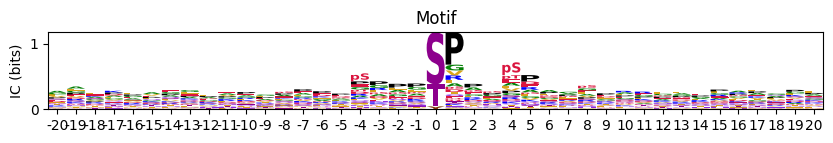

In [ ]:
plot_logo(pssm_df,figsize=(10,1))

In [ ]:
plt.close('all')

### Logo motif of log-odds

In [ ]:
#| export
def plot_logo_LO(pssm_LO,title='Motif', acceptor=None, scale_zero=True,scale_pos_neg=True,ax=None,figsize=(10,1)):
    "Plot logo of log-odds given a frequency PSSM."
    if acceptor is not None: 
        acceptor = acceptor.upper()
        assert acceptor in ['S','T','Y']
        pssm_LO= pssm_LO.copy()
        pssm_LO.loc[acceptor,0]=0.1 # give it a value so that it can be shown on the motif

    # return pssm_LO
    pssm_LO= convert_logo_df(pssm_LO,scale_zero=scale_zero,scale_pos_neg=scale_pos_neg)
    ytitle = "Scaled Log-Odds" if scale_pos_neg else "Log-Odds (bits)"
    plot_logo_raw(pssm_LO,ax=ax,title=title,ytitle=ytitle,figsize=figsize)

To ensure the phosphorylated residue is visible at the center of a log-odds motif (position 0), two mechanisms are used:

1. **Acceptor override**:
   If the center column is entirely zero (e.g., masked), the user can specify an `acceptor` (`'S'`, `'T'`, `'Y'`, or `'STY'`). The function then assigns a small nonzero value (e.g., 0.1) to the corresponding phospho-residue row (`pS`, `pT`, `pY`) at position 0. This ensures the central letter appears in the logo plot, even when real log-odds values are absent.

2. **Stack height rescaling**:
   To maintain visual consistency with surrounding columns, position 0 is rescaled so that its total positive and negative stack heights match the most extreme values observed elsewhere.

Together, these adjustments ensure that:
- The phospho-acceptor appears explicitly at the center,
- The visual scale remains consistent with neighboring positions,
- The resulting logo can faithfully reflect both biological relevance and statistical signal.


In [ ]:
pssm_LO = get_pssm_LO(pssm_df,'STY')
# plot_logo_LO(pssm_LO,scale_zero=False,scale_pos_neg=False)

In [ ]:
## with zero position scaled to the max
# plot_logo_LO(pssm_LO,scale_zero=True,scale_pos_neg=False)

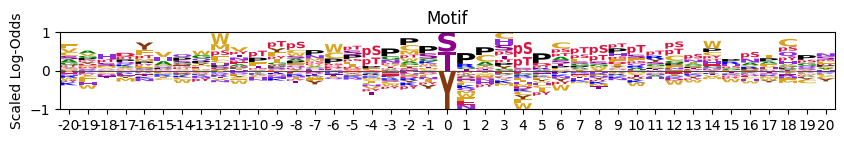

In [ ]:
# # scaled positive and negative values for better visualization
plot_logo_LO(pssm_LO,scale_zero=True,scale_pos_neg=True)

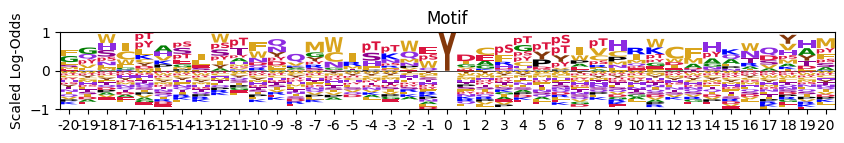

In [ ]:
# for those specific site type (S,T or Y), show acceptor in the middle instead of empty
pssm_LO = get_pssm_LO(pssm_y,'Y')
plot_logo_LO(pssm_LO,acceptor='Y')

In [ ]:
plt.close('all')

### Multiple logos

As multiple figures:

In [ ]:
#| export
def plot_logos_idx(pssms_df,*idxs,figsize=(14,1)):
    "Plot logos of a dataframe with flattened PSSMs with index ad IDs."
    for idx in idxs:
        pssm = recover_pssm(pssms_df.loc[idx])
        plot_logo(pssm,title=f'Motif {idx}',figsize=figsize)
        plt.show()
        plt.close()

In [ ]:
pssms=Data.get_cddm()

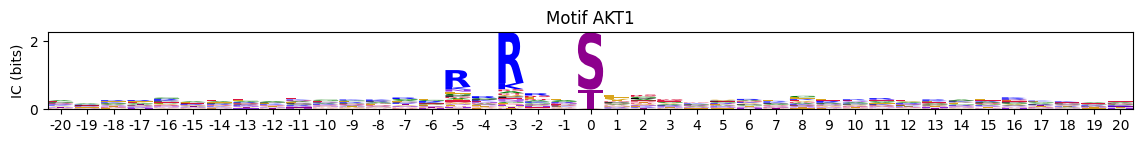

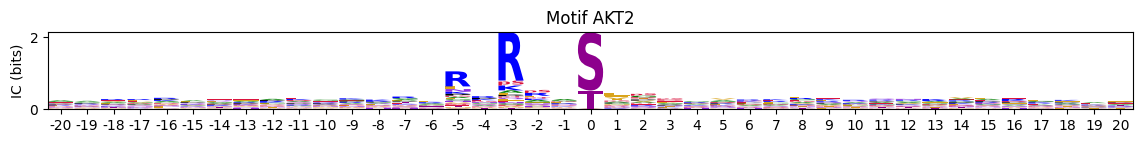

In [ ]:
plot_logos_idx(pssms,'AKT1','AKT2')

In one figure:

In [ ]:
#| export
def plot_logos(pssms_df, 
               count_dict=None, # used to display n in motif title
               path=None,
               prefix='Motif',
               figsize=(14,1)
               ):
    """
    Plot all logos from a dataframe of flattened PSSMs as subplots in a single figure.
    """
    n = len(pssms_df)
    hspace=0.7
    # 14 is width, 1 is height for each logo
    width,height=figsize
    fig, axes = plt.subplots(nrows=n, figsize=(width, n * (height+hspace)),gridspec_kw={'hspace': hspace+0.1})

    if n == 1:
        axes = [axes]  # ensure axes is iterable

    for ax, idx in zip(axes, pssms_df.index):
        pssm = recover_pssm(pssms_df.loc[idx])
        if count_dict is not None:
            plot_logo(pssm, title=f"{prefix or ''} {idx} (n={count_dict[idx]:,})",ax=ax)
        else:
            plot_logo(pssm, title=f"{prefix or ''} {idx}",ax=ax)

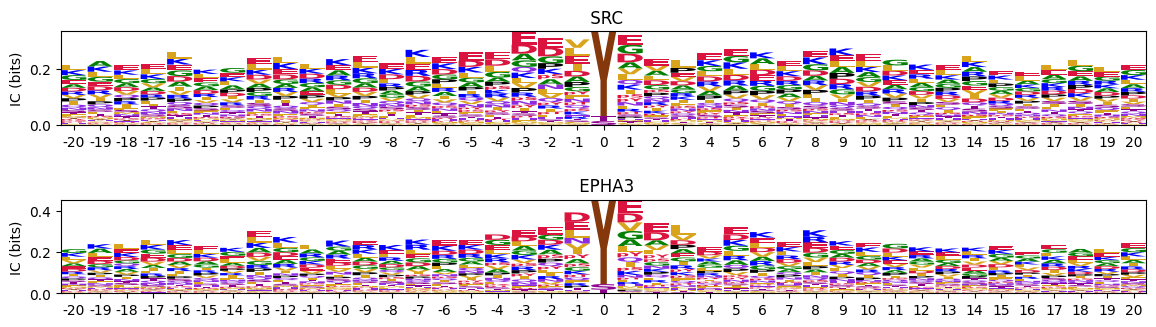

In [ ]:
plot_logos(pssms.head(2),prefix=None)

In [ ]:
plt.close('all')

### Logo motif + Heatmap

In [ ]:
#| export
def plot_logo_heatmap(pssm_df, # column is position, index is aa
                       title='Motif',
                       figsize=(17,10),
                       include_zero=False
                      ):
    
    """Plot logo and heatmap vertically"""
    
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 5], width_ratios=[4, 1], hspace=0.11, wspace=0)

    ax_logo = fig.add_subplot(gs[0, 0])
    plot_logo(pssm_df,ax=ax_logo,title=title)

    ax_heatmap = fig.add_subplot(gs[1, :])
    plot_heatmap(pssm_df,ax=ax_heatmap,position_label=False,include_zero=include_zero)

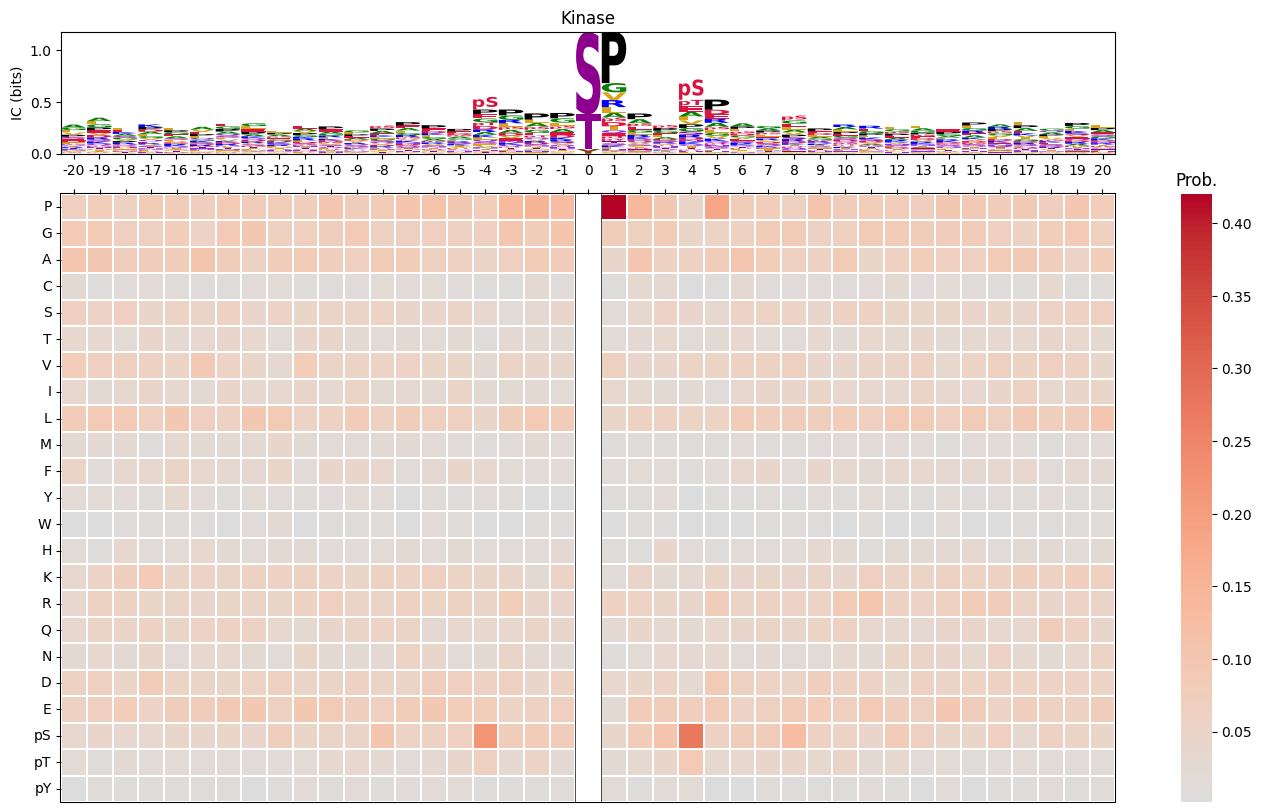

In [ ]:
plot_logo_heatmap(pssm_df,'Kinase',(17,10))

In [ ]:
#| export
def plot_logo_heatmap_LO(pssm_LO, # pssm of log-odds
                             title='Motif',
                         acceptor=None,
                             figsize=(17,10),
                             include_zero=False,
                         scale_pos_neg=True
                      ):
    
    """Plot logo and heatmap of enrichment bits vertically"""
    
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 5], width_ratios=[4, 1], hspace=0.11, wspace=0)

    ax_logo = fig.add_subplot(gs[0, 0])
    plot_logo_LO(pssm_LO,acceptor=acceptor,ax=ax_logo,title=title)

    ax_heatmap = fig.add_subplot(gs[1, :])
    plot_heatmap(pssm_LO,ax=ax_heatmap,position_label=False,include_zero=include_zero,scale_pos_neg=scale_pos_neg,colorbar_title='bits')

In [ ]:
# plot_logo_heatmap_LO(pssm_LO,acceptor='Y')

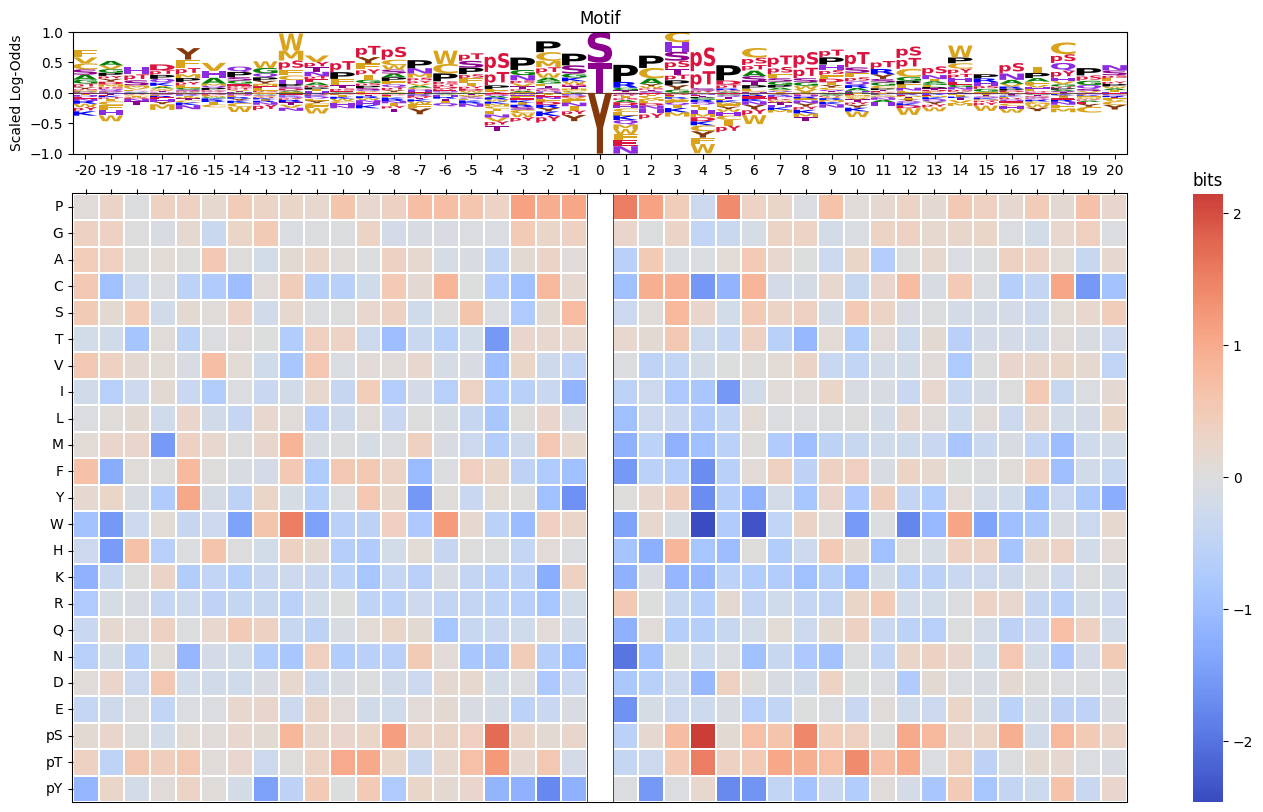

In [ ]:
pssm_LO = get_pssm_LO(pssm_df,'STY')
plot_logo_heatmap_LO(pssm_LO,scale_pos_neg=False) # normal color scale

In [ ]:
plt.close('all')

## PSPA

### Plot

In [ ]:
#| export
def preprocess_pspa(pssm):
    pssm = change_center_name(pssm)
    pssm = pssm.drop(index='s')
    pssm.index = pssm.index.map(lambda x: x.replace('t','pS/pT').replace('y','pY'))
    # pssm = np.log2(pssm/pssm.median()) # have to do it without position 0
    non_zero_cols = pssm.columns != 0
    pssm.loc[:, non_zero_cols] = np.log2(
        pssm.loc[:, non_zero_cols] / pssm.loc[:, non_zero_cols].median()
    )
    pssm=scale_zero_position(pssm)
    return pssm

In [ ]:
row = pspa.loc['GSK3B']
pssm = recover_pssm(row.dropna())
pssm = preprocess_pspa(pssm)
pssm

Position,-5,-4,-3,-2,-1,0,1,2,3,4
aa,,,,,,,,,,
P,0.128793,0.103768,0.327105,0.377614,0.200697,0.0,0.857330,-0.156606,-0.022523,0.020985
G,0.267518,0.232140,0.709128,0.215152,0.186051,0.0,-0.070893,-0.132404,-0.032647,-0.138561
...,...,...,...,...,...,...,...,...,...,...
pS/pT,-0.112011,0.206940,0.355120,0.106174,-0.114481,0.0,0.055519,-0.004874,1.836501,6.163857
pY,-0.106727,0.196308,0.158811,0.259140,0.699151,0.0,0.222213,0.047855,1.191558,1.496894


In [ ]:
#| export
def plot_logo_pspa(row,title='Motif',figsize=(5,2)):
    pssm = recover_pssm(row.dropna())
    logo_pssm = preprocess_pspa(pssm)
    plot_logo_raw(logo_pssm,ytitle='log₂(Value / Median)',title=title,figsize=figsize)

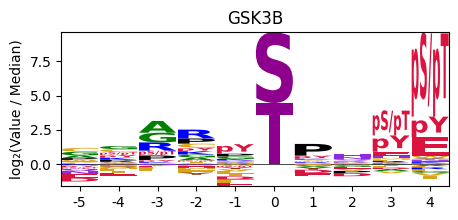

In [ ]:
plot_logo_pspa(pspa.loc['GSK3B'],title='GSK3B')

In [ ]:
#| export
def plot_logo_heatmap_pspa(row, # row of Data.get_pspa()
                       title='Motif',
                       figsize=(6,10),
                       include_zero=False
                      ):

    """Plot logo and heatmap vertically"""
    pssm = recover_pssm(row.dropna())
    
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 5], width_ratios=[4, 1], hspace=0.11, wspace=0)

    ax_logo = fig.add_subplot(gs[0, 0])
    
    logo_pssm = preprocess_pspa(pssm)
    plot_logo_raw(logo_pssm,ax=ax_logo, ytitle='log₂(Value / Median)',title=title)

    ax_heatmap = fig.add_subplot(gs[1, :])
    plot_heatmap(pssm,ax=ax_heatmap,position_label=False,include_zero=include_zero,colorbar_title='Value')

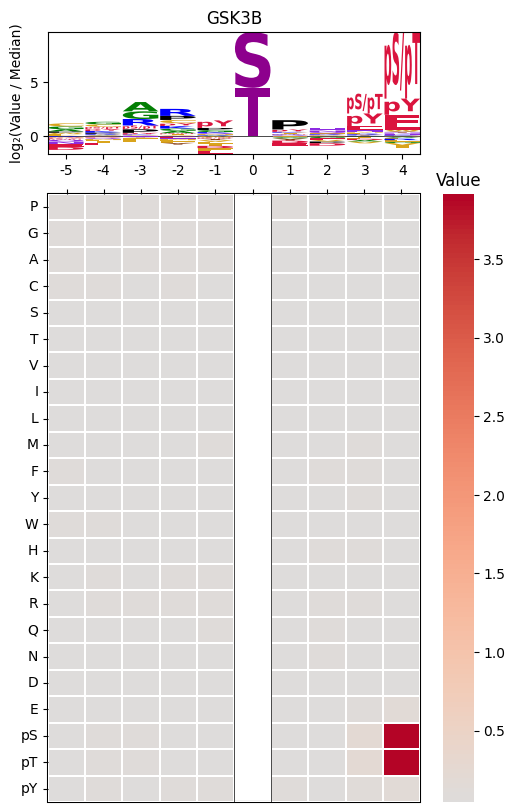

In [ ]:
plot_logo_heatmap_pspa(pspa.loc['GSK3B'],title='GSK3B')

### Calculations

In [ ]:
#| export
def raw2norm(df: pd.DataFrame, # single kinase's df has position as index, and single amino acid as columns
             PDHK: bool=False, # whether this kinase belongs to PDHK family 
            ):
    
    "Normalize single ST kinase data"
    columns_to_exclude = ['S', 'T', 'C', 't', 'y']
    
    if PDHK:
        columns_to_exclude.append('Y')
        divisor = 16
    else:
        divisor = 17
    
    s = df.drop(columns=columns_to_exclude).sum(1)
    df2 = df.div(s, axis=0)
    df2.C = df2.C / (df2.C.median() * divisor)
    df2['S'] = df2.drop(columns=columns_to_exclude).median(1)
    df2['T'] = df2.drop(columns=columns_to_exclude).median(1)
    df2 = round(df2, 4)
    
    return df2

This function implement the normalization method from [Johnson et al. Nature: An atlas of substrate specificities for the human serine/threonine kinome](https://www.nature.com/articles/s41586-022-05575-3#Sec6)

Specifically,
> - matrices were column-normalized at all positions by the sum of the 17 randomized amino acids (excluding serine, threonine and cysteine), to yield PSSMs. 
>- PDHK1 and PDHK4 were normalized to the 16 randomized amino acids (excluding serine, threonine, cysteine and additionally tyrosine)
>- The cysteine row was scaled by its median to be 1/17 (1/16 for PDHK1 and PDHK4). 
>- The serine and threonine values in each position were set to be the median of that position.
>- The S0/T0 ratio was determined by summing the values of S and T rows in the matrix (SS and ST, respectively), accounting for the different S vs. T composition of the central (1:1) and peripheral (only S or only T) positions (Sctrl and Tctrl, respectively), and then normalizing to the higher value among the two (S0 and T0, respectively, Supplementary Note 1)

This function is usually implemented with the below function, with `normalize` being a bool argument.

In [ ]:
#| export
def get_one_kinase(df: pd.DataFrame, #stacked dataframe (paper's raw data)
                   kinase:str, # a specific kinase
                   normalize: bool=False, # normalize according to the paper; special for PDHK1/4
                   drop_s: bool= True, # drop s as s is a duplicates of t in PSPA
                  ):
    "Obtain a specific kinase data from stacked dataframe"
    
    p = pd.DataFrame(df.loc[kinase],columns = [kinase]).reset_index().rename(columns={'index':'substrate'})
    p['position'] = p.substrate.str.extract(r'(-?\d+)')
    p['aa'] = p.substrate.str[-1]
    p.position = p.position.astype(int)
    pp = p.pivot(index='position', columns='aa', values=kinase)
    if drop_s:
        if 's' in pp.columns:
            pp = pp.drop(columns=['s'])

    if normalize:
        pp = raw2norm(pp, PDHK=True if kinase == 'PDHK1' or kinase == 'PDHK4' else False)
    return pp

Retreive a single kinase data from PSPA data that has an format of kinase as index and position+amino acid as column.

In [ ]:
data = Data.get_pspa_st()

In [ ]:
get_one_kinase(data,'PDHK1')

aa,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y,t,y
position,,,,,,,,,,,,,,,,,,,,,,
-5,0.0594,0.0625,0.0589,0.0550,0.0775,0.0697,0.0687,0.0590,0.0515,0.0657,0.0687,0.0613,0.0451,0.0424,0.0594,0.0594,0.0594,0.0573,0.1001,0.0775,0.0583,0.0658
-4,0.0618,0.0621,0.0550,0.0511,0.0739,0.0715,0.0598,0.0601,0.0520,0.0614,0.0744,0.0549,0.0637,0.0552,0.0617,0.0608,0.0608,0.0519,0.0916,0.0739,0.0528,0.0752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,0.0486,0.0609,0.0938,0.0684,0.1024,0.0676,0.0544,0.0583,0.0388,0.0552,0.0637,0.0505,0.0686,0.0502,0.0561,0.0588,0.0588,0.0593,0.0641,0.1024,0.0539,0.0431
4,0.0565,0.0749,0.0631,0.0535,0.0732,0.0655,0.0664,0.0625,0.0496,0.0552,0.0627,0.0640,0.0677,0.0553,0.0604,0.0626,0.0626,0.0579,0.0864,0.0732,0.0548,0.0575


### Plot PSPA logo motif (old)

In [ ]:
#| export
def get_logo(df: pd.DataFrame, # stacked Dataframe with kinase as index, substrates as columns
             kinase: str, # a specific kinase name in index
             ):
    "Given stacked df (index as kinase, columns as substrates), get a specific kinase's logo"
    
    
    # get raw kinase to calculate S/T
    pp = get_one_kinase(df,kinase,normalize=False)
    
    # get S/T ratio value
    ss = pp['S'].sum()
    st = pp['T'].sum()

    S_ctrl = 0.75*ss - 0.25*st
    T_ctrl = 0.75*st - 0.25*ss

    S0 = S_ctrl / max(S_ctrl, T_ctrl)
    T0 = T_ctrl / max(S_ctrl, T_ctrl)

    S_ratio = S0/(S0+T0)
    T_ratio = T0/(S0+T0)
    
    # get normalized kinase
    norm_p = get_one_kinase(df,kinase, normalize=True)
    
    # calculate ratio, divide values by median, followed by log2 transformation
    ratio =norm_p.apply(lambda r: r/r.median(),axis=1)
    ratio = np.log2(ratio)

    m = ratio.apply(lambda row: row[row > 0].sum(), axis=1).max()

    new_row = pd.DataFrame({'S': S_ratio*m, 'T':T_ratio*m}, index=[0]) 

    ratio2 = pd.concat([ratio, new_row], ignore_index=False).fillna(0)
    
    # plot logo
    # logo_func(ratio2, kinase)
    plot_logo_raw(ratio2.T,title=kinase,ytitle='log₂(Value / Median)')

This function is to replicate the motif logo from [Johnson et al. Nature: An atlas of substrate specificities for the human serine/threonine kinome](https://www.nature.com/articles/s41586-022-05575-3). Given raw PSPA data, it can output a motif logo.

In [ ]:
# load raw PSPA data
# df = pd.read_csv('https://github.com/sky1ove/katlas_raw/raw/refs/heads/main/nbs/raw/pspa_st_raw.csv').set_index('kinase')
# df.head()
# get_logo(df, 'AAK1')

## Compare PSSM

In [ ]:
pssms = Data.get_pspa_scale()

In [ ]:
# one example
pssm_df = recover_pssm(pssms.iloc[1])
pssm_df2 = recover_pssm(pssms.iloc[0])

### KL divergence

In [ ]:
#| export
def kl_divergence(p1,  # target pssm p (array-like, shape: (AA, positions))
                  p2,  # pred pssm q (array-like, same shape as p1)
                 ):
    """
    KL divergence D_KL(p1 || p2) over positions.
    
    p1 and p2 are arrays (df or np) with index as aa and column as position.
    Returns average divergence across positions if mean=True, else per-position.
    """
    assert p1.shape == p2.shape
    p1, p2 = p1.align(p2, join='inner', axis=None)
    # Mask invalid positions (both zero)
    valid = (p1 + p2) > 0
    p1 = np.where(valid, p1, 0.0)
    p2 = np.where(valid, p2, 0.0)

    # KL divergence: sum_x p1(x) log(p1(x)/p2(x))
    kl = np.sum(p1 * np.log((p1 + EPSILON) / (p2 + EPSILON)), axis=0)

    return kl

The Kullback–Leibler (KL) divergence between two probability distributions \( P \) and \( Q \) is defined as:

$$
\mathrm{KL}(P \| Q) = \sum_{x \in \mathcal{X}} P(x) \log \left( \frac{P(x)}{Q(x)} \right)
$$

This measures the information lost when \( Q \) is used to approximate \( P \). It is **not symmetric**, i.e.,

$$
\mathrm{KL}(P \| Q) \ne \mathrm{KL}(Q \| P)
$$

and it is **non-negative**, meaning:

$$
\mathrm{KL}(P \| Q) \ge 0
$$

with equality if and only if \( P = Q \) almost everywhere.

In practical computation, to avoid numerical instability when \( P(x) = 0 \) or \( Q(x) = 0 \), we often add a small constant \( \varepsilon \):

$$
\mathrm{KL}_\varepsilon(P \| Q) = \sum_{x \in \mathcal{X}} P(x) \log \left( \frac{P(x) + \varepsilon}{Q(x) + \varepsilon} \right)
$$

In [ ]:
kl_divergence(pssm_df,pssm_df2)

array([0.29182172, 0.11138481, 0.24590698, 0.46021635, 0.36874823,
       0.53858511, 1.51571614, 0.02905442, 0.08530757, 0.07753394])

In [ ]:
kl_divergence(pssm_df,pssm_df2).mean(),kl_divergence(pssm_df,pssm_df2).max()

(np.float64(0.37242752573216287), np.float64(1.5157161422110503))

In [ ]:
#| export
def kl_divergence_flat(p1_flat, # pd.Series of target flattened pssm p
                       p2_flat, # pd.Series of pred flattened pssm q
                       ):

    "p1 and p2 are two flattened pd.Series with index as aa and column as position"
    kld = kl_divergence(p1_flat,p2_flat) # do not do js.mean() because it's 1d
    total_position = len(p1_flat.index.str.extract(r'(-?\d+)').drop_duplicates())
    return float(kld/total_position)

In [ ]:
%%time
kl_divergence_flat(pssms.iloc[1],pssms.iloc[0])

CPU times: user 1.38 ms, sys: 30 μs, total: 1.41 ms
Wall time: 1.39 ms


0.37242752573216287

### JS divergence

In [ ]:
#| export
def js_divergence(p1, # pssm 
                  p2, # pssm
                  index=True,
                 ):
    "p1 and p2 are two arrays (df or np) with index as aa and column as position"
    assert p1.shape==p2.shape
    p1, p2 = p1.align(p2, join='inner', axis=None)
    if index: positions=p1.columns
    valid = (p1 + p2) > 0
    p1 = np.where(valid, p1, 0.0)
    p2 = np.where(valid, p2, 0.0)
    
    m = 0.5 * (p1 + p2)
    
    js = 0.5 * np.sum(p1 * np.log((p1+ EPSILON) / (m + EPSILON)), axis=0) + \
         0.5 * np.sum(p2 * np.log((p2+ EPSILON) / (m + EPSILON)), axis=0)
    return pd.Series(js,index=positions) if index else js

The Jensen-Shannon divergence between two probability distributions $ P $ and $ Q $ is defined as:

$$
\mathrm{JS}(P \| Q) = \frac{1}{2} \, \mathrm{KL}(P \| M) + \frac{1}{2} \, \mathrm{KL}(Q \| M)
$$

where $ M = \frac{1}{2}(P + Q) $ is the average (mixture) distribution, and $ \mathrm{KL} $ denotes the Kullback–Leibler divergence:

$$
\mathrm{KL}(P \| Q) = \sum_{x \in \mathcal{X}} P(x) \log \left( \frac{P(x)}{Q(x)} \right)
$$

Therefore,

$$
\mathrm{JS}_\varepsilon(P \| Q) = \frac{1}{2} \sum_{x \in \mathcal{X}} P(x) \log \left( \frac{P(x) + \varepsilon}{M(x) + \varepsilon} \right)
+ \frac{1}{2} \sum_{x \in \mathcal{X}} Q(x) \log \left( \frac{Q(x) + \varepsilon}{M(x) + \varepsilon} \right)
$$

In [ ]:
js_divergence(pssm_df,pssm_df2)

Position
-5    0.065539
-4    0.025712
        ...   
 3    0.020949
 4    0.018206
Length: 10, dtype: float64

In [ ]:
js_divergence(pssm_df,pssm_df2).max(),js_divergence(pssm_df,pssm_df2).mean()

(np.float64(0.34404931056288773), np.float64(0.08286124552178498))

In [ ]:
#| export
def js_divergence_flat(p1_flat, # pd.Series of flattened pssm
                       p2_flat, # pd.Series of flattened pssm
                       ):

    "p1 and p2 are two flattened pd.Series with index as aa and column as position"
    js = js_divergence(p1_flat,p2_flat,index=False)
    total_position = len(p1_flat.index.str.extract(r'(-?\d+)').drop_duplicates())
    return float(js/total_position)

In [ ]:
%%time
js_divergence_flat(pssms.iloc[1],pssms.iloc[0])

CPU times: user 0 ns, sys: 1.72 ms, total: 1.72 ms
Wall time: 1.7 ms


0.08286124552178498

### JS similarity

To convert the Jensen–Shannon divergence into a similarity measure, we first normalize it to bits by dividing by log(2), ensuring that the divergence lies within the range [0, 1]. 
$$
\mathrm{JS}_{\text{bits}}(P \| Q) = \frac{\mathrm{JS}(P \| Q)}{\log 2}
$$

The similarity is then defined as one minus this normalized divergence:
$$
\mathrm{Sim}_{\mathrm{JS}}(P, Q) = 1 - \mathrm{JS}_{\text{bits}}(P \| Q)
$$

Thus, $\mathrm{Sim}_{\mathrm{JS}}$ ranges from 0 (completely dissimilar) to 1 (identical distributions).

In [ ]:
#| export
def js_similarity(pssm1,pssm2):
    "Convert JSD to bits to be in range (0,1) then 1-JSD."
    distance = js_divergence(pssm1,pssm2)/np.log(2)
    similarity = 1-distance
    return similarity

In [ ]:
js_similarity(pssm_df,pssm_df2).mean()

np.float64(0.880456492003838)

In [ ]:
#| export
def js_similarity_flat(p1_flat,p2_flat):
    "Convert JSD to bits to be in range (0,1) then 1-JSD. "
    return 1-(js_divergence_flat(p1_flat,p2_flat)/np.log(2))

In [ ]:
js_similarity_flat(pssms.iloc[1],pssms.iloc[0])

np.float64(0.880456492003838)

### Cosine similarity

In [ ]:
#| export
def cosine_similarity(pssm1: pd.DataFrame, pssm2: pd.DataFrame) -> pd.Series:
    "Compute cosine similarity per position (column) between two PSSMs."
    
    assert pssm1.shape == pssm2.shape, "PSSMs must have the same shape"
    
    sims = {}
    for pos in pssm1.columns:
        v1 = pssm1[pos]
        v2 = pssm2[pos]
        v1,v2 = v1.align(v2, join='inner') # make sure the aa index match with each other

        norm1 = np.linalg.norm(v1)
        norm2 = np.linalg.norm(v2)

        if norm1 == 0 or norm2 == 0:
            sims[pos] = 0.0
        else:
            dot_product = sum(v1*v2) # np.dot(v1,v2)
            sims[pos] = dot_product / (norm1 * norm2)

    return pd.Series(sims)

The cosine similarity between two vectors \( P \) and \( Q \) (e.g., two PSSM columns representing amino acid probability distributions) is defined as:

$$
\mathrm{cos}(P, Q) = \frac{P \cdot Q}{\|P\| \, \|Q\|}
$$

where $ P \cdot Q = \sum_{i=1}^{n} P_i Q_i $ is the dot product between $ P $ and $ Q $, and $ \|P\| = \sqrt{\sum_{i=1}^{n} P_i^2} $ is the Euclidean norm of $ P $.

Since all entries of $ P $ and $ Q $ are nonnegative probabilities (i.e., $ P_i, Q_i \in [0,1] $), the cosine similarity lies within the range:

$$
0 \leq \mathrm{cos}(P, Q) \leq 1
$$


Given that pssm are probabilities between 0 and 1, cosine similarity is within (0,1)

In [ ]:
cosine_similarity(pssm_df,pssm_df2).sort_values()

 1    0.130818
-2    0.606234
        ...   
 4    0.934967
 2    0.971066
Length: 10, dtype: float64

In [ ]:
cosine_similarity(pssm_df,pssm_df2).mean()

np.float64(0.754148470457778)

In [ ]:
#| export
def cosine_overall_flat(pssm1_flat, pssm2_flat):
    """Compute overall cosine similarity between two PSSMs (flattened)."""
    # match index for dot product
    pssm1_flat, pssm2_flat = pssm1_flat.align(pssm2_flat, join='inner')
    norm1 = np.linalg.norm(pssm1_flat)
    norm2 = np.linalg.norm(pssm2_flat)
    if norm1 == 0 or norm2 == 0: return 0.0
    dot_product = sum(pssm1_flat*pssm2_flat) # np.dot(pssm1_flat, pssm2_flat)
    return  dot_product/ (norm1 * norm2)

In [ ]:
cosine_overall_flat(pssms.iloc[0],pssms.iloc[0])

np.float64(1.0000000000000004)

In [ ]:
cosine_overall_flat(pssms.iloc[0],pssms.iloc[1])

np.float64(0.6614783212500965)

## End

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

In [ ]:
#| hide

# Sometimes we need to duplicate values at zero positions to ensure that the scoring function treat zero position S/T/Y same as s/t/y.
# def duplicate_zero(pssm_df):
#     """
#     For position 0, synchronize values across standard (S, T, Y) and their
#     phosphorylated variants (s, t, y or pS, pT, pY). Any non-zero value is
#     treated as meaningful and copied to all variants in the group.
#     """
#     pssm_df = pssm_df.copy()

#     variant_groups = [
#         ['S', 's', 'pS'],
#         ['T', 't', 'pT'],
#         ['Y', 'y', 'pY']
#     ]

#     for group in variant_groups:
#         # Filter to existing amino acids in index
#         present = [aa for aa in group if aa in pssm_df.index]
#         if not present:
#             continue

#         # Look for non-zero value in existing variants
#         shared_value = 0
#         for aa in present:
#             val = pssm_df.at[aa, 0]
#             if val != 0:
#                 shared_value = val
#                 break  # prefer the first non-zero one

#         # Assign the shared value to all existing variants
#         for aa in present:
#             pssm_df.at[aa, 0] = shared_value

#     return pssm_df

# pssm_df[0].to_dict() # original

# duplicate_zero(pssm_df)[0].to_dict() # after














# def get_freq(df_k: pd.DataFrame, # a dataframe for a single kinase that contains phosphorylation sequence splitted by their position
#              aa_order = [i for i in 'PGACSTVILMFYWHKRQNDEsty'], # amino acid to include in the full matrix 
#              aa_order_paper = [i for i in 'PGACSTVILMFYWHKRQNDEsty'], # amino acid to include in the partial matrix
#              position = [i for i in range(-7,8)], # position to include in the full matrix
#              position_paper = [-5,-4,-3,-2,-1,1,2,3,4] # position to include in the partial matrix
#              ):
    
#     "Get frequency matrix given a dataframe of phosphorylation sites for a single kinase"
    

#     #Count frequency for each amino acid at each position
#     melted_k = df_k.melt(
#                     value_vars=[i for i in range(-7, 8)],
#                     var_name='Position', 
#                     value_name='aa')
    
#     # Group by Position and Amino Acid and count occurrences
#     grouped = melted_k.groupby(['Position', 'aa']).size().reset_index(name='Count')
    

#     # Remove wired amino acid
#     aa_include = [i for i in 'PGACSTVILMFYWHKRQNDEsty']
#     grouped = grouped[grouped.aa.isin(aa_include)].reset_index(drop=True)
    
#     # get pivot table
#     pivot_k = grouped.pivot(index='aa', columns='Position', values='Count').fillna(0)
    
#     # Get frequency by dividing the sum of each column
#     freq_k = pivot_k/pivot_k.sum()

    
#     # data from the kinase-substrate dataset, and format is Lew's paper's format
#     paper = freq_k.reindex(index=aa_order_paper,columns=position_paper,fill_value=0)

#     # full pivot data from kinase-substrate dataset
#     full = freq_k.reindex(index=aa_order,columns=position, fill_value=0)

    
#     return paper,full

# # get frequency matrix
# paper_format, full = get_freq(data_k)
# paper_format.head()

# def get_unique_site(df:pd.DataFrame = None,# dataframe that contains phosphorylation sites
#                     seq_col: str='site_seq', # column name of site sequence
#                     id_col: str='gene_site' # column name of site id
#                    ):
#     "Remove duplicates among phosphorylation sites; return df with new columns of acceptor and number of duplicates"
    
#     unique = df.groupby(seq_col).agg(
#         {id_col: lambda r: '|'.join(r.unique())} )
#     unique['num_site'] = unique[id_col].str.split('|').apply(len) 
#     unique = unique.reset_index()
#     position = len(unique[seq_col][0])//2
#     unique['acceptor'] = unique[seq_col].str[position]
    
#     return unique

# As there are lots of duplicates of the phosphorylation site sequence in the dataset, it could be helpful to remove the duplicated sequences. 

# Implement `get_unique_site` to get unique phosphorylation sites. Need to inform columns of sequence and id.

# df = Data.get_ochoa_site()
# unique = get_unique_site(df,seq_col='site_seq',id_col='gene_site')
# unique.sort_values('num_site',ascending=False).head()

# #| export
# def scale_zero_position(pssm_df):
#     "Scale position 0 to the max sum of neigboring position for better visualization."
#     pssm_df = pssm_df.copy()
#     m = pssm_df.sum()[pssm_df.sum().index!=0].max()
#     pssm_df[0] = m*(pssm_df[0]/pssm_df[0].sum())
#     return pssm_df